In [7]:
from os.path import join, dirname
from glob import glob

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import cm, colors, patches, lines

from scipy import optimize, stats
from scipy.stats import ttest_ind

from nilearn import image, plotting, masking
from nilearn.maskers import NiftiLabelsMasker

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm

import pingouin as pg

# Preprocessing

In [8]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

In [9]:
dir_root = join('/mnt/ext5/GP/fmri_data')
dir_stat = join(dir_root,'stats/AM/GLM.reward_per_trial/5.0s_shifted')
dir_mask = join(dir_root,'masks')

In [10]:
list_run = [f'r{run+1:02}' for run in range(3)]
list_run

['r01', 'r02', 'r03']

In [11]:
list_dlPFC_cTBS = [
    '09', '10', '18', '21', '22'
    , '24', '27', '34', '35', '36'
    , '38', '42', '57', '59', '62'
    , '66', '67'
]
list_M1_cTBS = [
    '08', '11', '17', '19', '20'
    , '26', '32', '33', '37', '39'
    , '40', '41', '56', '58', '61'
    , '63', '65'
]
## GP50은 GP26과 동일인물
list_dlPFC_20Hz = [
    '43', '44', '45', '46', '47'
    , '48', '49', '51', '53', '54'
    , '55',
    '71', '72', '73', '74', '75'
#     , '50'
]
list_subj = sorted(list_dlPFC_cTBS+list_M1_cTBS+list_dlPFC_20Hz)

In [12]:
list_GA = []
list_ = glob(join('/mnt/ext5/GA/fmri_data/raw_data/GA??'))
for dname in list_:
    list_GA.append(dname.split('/')[-1])

In [13]:
dx = pd.DataFrame(index=list_GA)
dx['group'] = 'no_stim'

In [14]:
dy = pd.DataFrame()
for nn in list_subj:
    subj = 'GP%s'%nn
    group = 'DLPFC_cTBS' if nn in list_dlPFC_cTBS else ('M1_cTBS' if nn in list_M1_cTBS else 'DLPFC_20Hz')
    new_row = pd.Series(data=group, name=subj)

    dy = pd.concat(
        [dy, new_row.to_frame().T]
        , axis='index'
        , ignore_index=False
    )
dy = dy.rename({0:'group'}, axis='columns')

In [15]:
dz = pd.concat([dx, dy])

In [16]:
# fig, axs = plt.subplots(nrows=2)

imgs = {}
for ii, roi in enumerate(['caudate','putamen']):
#    ax = axs[ii]
    imgs[roi] = image.load_img(
        join(dir_mask,f'mask.TTatlas.{roi}.resampled.nii'),
    )
#     plotting.plot_glass_brain(
#         imgs[roi],
#         title=roi,
#         cmap=cm.jet, colorbar=True,
#         axes=ax
#    )

In [17]:
dict_roi = {}
## Putamen
dict_roi['raPU'] = 1
dict_roi['laPU'] = 2
dict_roi['lpPU'] = 3
dict_roi['rpPU'] = 4
## Caudate
dict_roi['laCA'] = 1
dict_roi['lpCA'] = 2
dict_roi['raCA'] = 3
dict_roi['rpCA'] = 4

In [18]:
img_mask = image.math_img(
    img1=imgs['putamen'], img2=imgs['caudate'],
    formula='img1 + (img2+4)*(img2>0)'
)

In [19]:
# plotting.view_img(
#     img_mask,
#     cmap=cm.jet.resampled(9), colorbar=True, symmetric_cmap=False,
#     resampling_interpolation='nearest'
# )

In [53]:
list_label=[
    'raPU', 'laPU', 'lpPU', 'rpPU',
    'laCA', 'lpCA', 'raCA', 'rpCA'
]

In [21]:
dict_nvoxels = {}
tmp = img_mask.get_fdata().astype(int)
for ii, l in enumerate(list_label):
    dict_nvoxels[l] = len(tmp[tmp==ii+1])
dict_nvoxels

{'raPU': 135,
 'laPU': 133,
 'lpPU': 132,
 'rpPU': 105,
 'laCA': 71,
 'lpCA': 103,
 'raCA': 66,
 'rpCA': 109}

In [54]:
masker = NiftiLabelsMasker(
    labels_img=img_mask, labels=list_label,
    memory='/home/sungbeenpark/trash/nilearn_cache', verbose=0
)

In [23]:
prop = 'Rew#1_Coef'

In [55]:
df = pd.DataFrame()

for run in list_run:
    print(run)
    
    ## GA
    a = sorted(glob(join(
            '/mnt/ext5/GA/fmri_data/stats/AM/GLM.reward_per_trial/5.0s_shifted'
            , f'GA??/{prop}.{run}.GA??.nii'
        )))
    ## GP
    p = sorted(glob(join(dir_stat,f'GP??/{prop}.{run}.GP??.nii')))
    # print(p)
    
    ## combining these as whole data set
    list_fname = np.concatenate([a,p])

    for fname in tqdm(list_fname):
        subj = fname.split('/')[-2]
        nn=subj[2:]

        group = dz.loc[subj,'group']

#         beta = masking.apply_mask(imgs=fname, mask_img=img)
        betas = masker.fit_transform(fname)[0]
        for ii, roi in enumerate(list_label):
            new_row = pd.Series(
                {
                    'subj':subj, 'group':group, 'run':run,
                    'roi':roi, 'roi_':roi[1:],
#                     'lr':roi[0], 'ap':roi[1], 'anat':roi[2:],
                    'beta':betas[ii],
                    'nvoxels':dict_nvoxels[roi]
                }
            )
            df = pd.concat(
                [df, new_row.to_frame().T]
                , axis='index'
                , ignore_index=True
            )
# df.set_index('subj', inplace=True)
# df.index.name = None

r01
['/mnt/ext5/GP/fmri_data/stats/AM/GLM.reward_per_trial/5.0s_shifted/GP08/Rew#1_Coef.r01.GP08.nii', '/mnt/ext5/GP/fmri_data/stats/AM/GLM.reward_per_trial/5.0s_shifted/GP09/Rew#1_Coef.r01.GP09.nii', '/mnt/ext5/GP/fmri_data/stats/AM/GLM.reward_per_trial/5.0s_shifted/GP10/Rew#1_Coef.r01.GP10.nii', '/mnt/ext5/GP/fmri_data/stats/AM/GLM.reward_per_trial/5.0s_shifted/GP11/Rew#1_Coef.r01.GP11.nii', '/mnt/ext5/GP/fmri_data/stats/AM/GLM.reward_per_trial/5.0s_shifted/GP17/Rew#1_Coef.r01.GP17.nii', '/mnt/ext5/GP/fmri_data/stats/AM/GLM.reward_per_trial/5.0s_shifted/GP18/Rew#1_Coef.r01.GP18.nii', '/mnt/ext5/GP/fmri_data/stats/AM/GLM.reward_per_trial/5.0s_shifted/GP19/Rew#1_Coef.r01.GP19.nii', '/mnt/ext5/GP/fmri_data/stats/AM/GLM.reward_per_trial/5.0s_shifted/GP20/Rew#1_Coef.r01.GP20.nii', '/mnt/ext5/GP/fmri_data/stats/AM/GLM.reward_per_trial/5.0s_shifted/GP21/Rew#1_Coef.r01.GP21.nii', '/mnt/ext5/GP/fmri_data/stats/AM/GLM.reward_per_trial/5.0s_shifted/GP22/Rew#1_Coef.r01.GP22.nii', '/mnt/ext5/GP/f

 89%|████████▉ | 71/80 [00:01<00:00, 53.16it/s]/home/kjh/anaconda3/envs/GP/lib/python3.9/site-packages/joblib/_store_backends.py:207: CacheWarning: Unable to cache to disk. Possibly a race condition in the creation of the directory. Exception: [Errno 13] Permission denied: '/home/sungbeenpark/trash/nilearn_cache/joblib/nilearn/maskers/base_masker/_filter_and_extract/00fd67f8bdf6fbed0195d115c88f74a5'.
  warnings.warn(
/home/kjh/anaconda3/envs/GP/lib/python3.9/site-packages/joblib/_store_backends.py:207: CacheWarning: Unable to cache to disk. Possibly a race condition in the creation of the directory. Exception: [Errno 13] Permission denied: '/home/sungbeenpark/trash/nilearn_cache/joblib/nilearn/maskers/base_masker/_filter_and_extract/f19ad13acc37d0a092d647178baeefbf'.
  warnings.warn(
 96%|█████████▋| 77/80 [00:01<00:00, 26.26it/s]/home/kjh/anaconda3/envs/GP/lib/python3.9/site-packages/joblib/_store_backends.py:207: CacheWarning: Unable to cache to disk. Possibly a race condition in the

r02
['/mnt/ext5/GP/fmri_data/stats/AM/GLM.reward_per_trial/5.0s_shifted/GP08/Rew#1_Coef.r02.GP08.nii', '/mnt/ext5/GP/fmri_data/stats/AM/GLM.reward_per_trial/5.0s_shifted/GP09/Rew#1_Coef.r02.GP09.nii', '/mnt/ext5/GP/fmri_data/stats/AM/GLM.reward_per_trial/5.0s_shifted/GP10/Rew#1_Coef.r02.GP10.nii', '/mnt/ext5/GP/fmri_data/stats/AM/GLM.reward_per_trial/5.0s_shifted/GP11/Rew#1_Coef.r02.GP11.nii', '/mnt/ext5/GP/fmri_data/stats/AM/GLM.reward_per_trial/5.0s_shifted/GP17/Rew#1_Coef.r02.GP17.nii', '/mnt/ext5/GP/fmri_data/stats/AM/GLM.reward_per_trial/5.0s_shifted/GP18/Rew#1_Coef.r02.GP18.nii', '/mnt/ext5/GP/fmri_data/stats/AM/GLM.reward_per_trial/5.0s_shifted/GP19/Rew#1_Coef.r02.GP19.nii', '/mnt/ext5/GP/fmri_data/stats/AM/GLM.reward_per_trial/5.0s_shifted/GP20/Rew#1_Coef.r02.GP20.nii', '/mnt/ext5/GP/fmri_data/stats/AM/GLM.reward_per_trial/5.0s_shifted/GP21/Rew#1_Coef.r02.GP21.nii', '/mnt/ext5/GP/fmri_data/stats/AM/GLM.reward_per_trial/5.0s_shifted/GP22/Rew#1_Coef.r02.GP22.nii', '/mnt/ext5/GP/f

 90%|█████████ | 72/80 [00:01<00:00, 52.66it/s]/home/kjh/anaconda3/envs/GP/lib/python3.9/site-packages/joblib/_store_backends.py:207: CacheWarning: Unable to cache to disk. Possibly a race condition in the creation of the directory. Exception: [Errno 13] Permission denied: '/home/sungbeenpark/trash/nilearn_cache/joblib/nilearn/maskers/base_masker/_filter_and_extract/e032e089ef91adf5e1e8b4f303dab789'.
  warnings.warn(
/home/kjh/anaconda3/envs/GP/lib/python3.9/site-packages/joblib/_store_backends.py:207: CacheWarning: Unable to cache to disk. Possibly a race condition in the creation of the directory. Exception: [Errno 13] Permission denied: '/home/sungbeenpark/trash/nilearn_cache/joblib/nilearn/maskers/base_masker/_filter_and_extract/2d351d9384d07880876368b49bf00bc6'.
  warnings.warn(
/home/kjh/anaconda3/envs/GP/lib/python3.9/site-packages/joblib/_store_backends.py:207: CacheWarning: Unable to cache to disk. Possibly a race condition in the creation of the directory. Exception: [Errno 1

r03
['/mnt/ext5/GP/fmri_data/stats/AM/GLM.reward_per_trial/5.0s_shifted/GP08/Rew#1_Coef.r03.GP08.nii', '/mnt/ext5/GP/fmri_data/stats/AM/GLM.reward_per_trial/5.0s_shifted/GP09/Rew#1_Coef.r03.GP09.nii', '/mnt/ext5/GP/fmri_data/stats/AM/GLM.reward_per_trial/5.0s_shifted/GP10/Rew#1_Coef.r03.GP10.nii', '/mnt/ext5/GP/fmri_data/stats/AM/GLM.reward_per_trial/5.0s_shifted/GP11/Rew#1_Coef.r03.GP11.nii', '/mnt/ext5/GP/fmri_data/stats/AM/GLM.reward_per_trial/5.0s_shifted/GP17/Rew#1_Coef.r03.GP17.nii', '/mnt/ext5/GP/fmri_data/stats/AM/GLM.reward_per_trial/5.0s_shifted/GP18/Rew#1_Coef.r03.GP18.nii', '/mnt/ext5/GP/fmri_data/stats/AM/GLM.reward_per_trial/5.0s_shifted/GP19/Rew#1_Coef.r03.GP19.nii', '/mnt/ext5/GP/fmri_data/stats/AM/GLM.reward_per_trial/5.0s_shifted/GP20/Rew#1_Coef.r03.GP20.nii', '/mnt/ext5/GP/fmri_data/stats/AM/GLM.reward_per_trial/5.0s_shifted/GP21/Rew#1_Coef.r03.GP21.nii', '/mnt/ext5/GP/fmri_data/stats/AM/GLM.reward_per_trial/5.0s_shifted/GP22/Rew#1_Coef.r03.GP22.nii', '/mnt/ext5/GP/f

 90%|█████████ | 72/80 [00:01<00:00, 52.46it/s]/home/kjh/anaconda3/envs/GP/lib/python3.9/site-packages/joblib/_store_backends.py:207: CacheWarning: Unable to cache to disk. Possibly a race condition in the creation of the directory. Exception: [Errno 13] Permission denied: '/home/sungbeenpark/trash/nilearn_cache/joblib/nilearn/maskers/base_masker/_filter_and_extract/788fa9b341a3794231449055fe8961e4'.
  warnings.warn(
/home/kjh/anaconda3/envs/GP/lib/python3.9/site-packages/joblib/_store_backends.py:207: CacheWarning: Unable to cache to disk. Possibly a race condition in the creation of the directory. Exception: [Errno 13] Permission denied: '/home/sungbeenpark/trash/nilearn_cache/joblib/nilearn/maskers/base_masker/_filter_and_extract/c80aba75e1203f023370b11698b1b24a'.
  warnings.warn(
/home/kjh/anaconda3/envs/GP/lib/python3.9/site-packages/joblib/_store_backends.py:207: CacheWarning: Unable to cache to disk. Possibly a race condition in the creation of the directory. Exception: [Errno 1

In [57]:
# df = df.astype({'beta':float, 'nvoxels':int})
# df.to_csv('./../data/df_rew1_coef_GPn50.csv', index=False)

In [33]:
# df = df.astype({'beta':float, 'nvoxels':int})
# df.to_csv('./../data/df_rew1_coef.csv', index=False)

# Figure 3 B

In [63]:
df = pd.read_csv('./../data/df_rew1_coef.csv')
df

,subj,group,run,roi,roi_,beta,nvoxels
0,GA01,no_stim,r01,raPU,aPU,0.518611,135
1,GA01,no_stim,r01,laPU,aPU,0.599993,133
2,GA01,no_stim,r01,lpPU,pPU,0.151185,132
3,GA01,no_stim,r01,rpPU,pPU,0.272298,105
4,GA01,no_stim,r01,laCA,aCA,0.538827,71
...,...,...,...,...,...,...,...
1795,GP67,DLPFC_cTBS,r03,rpPU,pPU,0.018424,105
1796,GP67,DLPFC_cTBS,r03,laCA,aCA,0.016947,71
1797,GP67,DLPFC_cTBS,r03,lpCA,pCA,-0.135706,103
1798,GP67,DLPFC_cTBS,r03,raCA,aCA,-0.021755,66


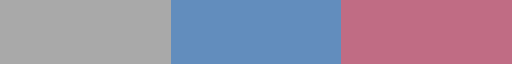

In [59]:
tmp = cm.turbo(np.linspace(0.1,1.0,4))
palette = [colors.rgb2hex(rgb, keep_alpha=False) for rgb in tmp][:3]

palette = ['#A9A9A9', '#628dbd', '#C06C84']

colors.ListedColormap(palette)

In [60]:
list_label = [
    'laCA', 'raCA', 'lpCA', 'rpCA',
    'laPU', 'raPU', 'lpPU', 'rpPU'
]

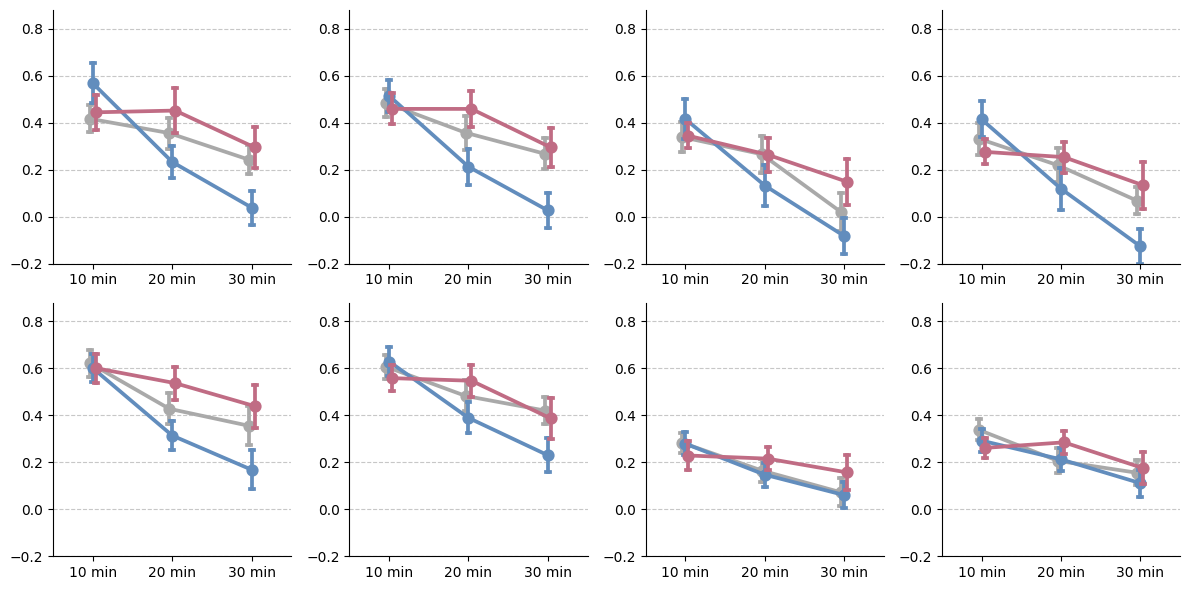

In [64]:
import warnings

# Ignore all future warnings
warnings.filterwarnings('ignore', category=FutureWarning)

order = ['r01','r02','r03']
hue_order = ['no_stim', 'DLPFC_cTBS','M1_cTBS']

ncols=4
nrows=2

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols,3*nrows))
axs = np.concatenate(axs)

for ii, roi in enumerate(list_label):
    ax = axs[ii]
    g = sns.pointplot(
        data=df[df.roi==roi], x='run', y='beta', hue='group',
        order=order, hue_order=hue_order, palette=palette,
        errorbar='se', capsize=0.05,
        dodge=True,
        ax=ax
    )
    ax.set_title(roi)
    ax.set_ylim(-0.2,0.88)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.legend().remove()
    
    ax.set_title(None)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    
    ax.set_xticklabels(['10 min', '20 min', '30 min'])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
fig.tight_layout()

# fname = '/home/kjh/Desktop/GP/figures/fig3/fig3C.png'
# plt.savefig(fname, dpi=600)
# plt.close()

## Statistics

### T-test

In [25]:
roi_list = ['laCA', 'raCA', 'laPU', 'raPU']

for roi in roi_list:
    print(roi)
    
    # Step 1: Filter the data for 'laCA' in runs 'r01' and 'r03'
    data = df[(df['roi'] == f'{roi}') & (df['run'].isin(['r01', 'r03']))]

    # Step 2: Pivot the data to get 'r01' and 'r03' as columns
    pivot = data.pivot_table(index=['subj', 'group'], columns='run', values='beta').reset_index()

    # Step 3: Calculate the difference 'r03 - r01'
    pivot['beta_diff'] = pivot['r03'] - pivot['r01']

    # Step 4: Separate the differences into two groups
    no_stim_diff = pivot[pivot['group'] == 'no_stim']['beta_diff']
    DLPFC_ctbs_diff = pivot[pivot['group'] == 'DLPFC_cTBS']['beta_diff']

    # Perform an independent t-test
    t_stat, p_value = ttest_ind(no_stim_diff, DLPFC_ctbs_diff)

    print(t_stat, p_value)

laCA
3.2224930007032246 0.0023649990411725792
raCA
2.550068678454148 0.014245114214607954
laPU
1.4296271687942552 0.15973032287182562
raPU
2.256861192283379 0.028919630006533886


In [26]:
roi_list = ['laCA', 'raCA', 'laPU', 'raPU']

for roi in roi_list:
    print(roi)
    
    # Step 1: Filter the data for 'laCA' in runs 'r01' and 'r03'
    data = df[(df['roi'] == f'{roi}') & (df['run'].isin(['r01', 'r03']))]

    # Step 2: Pivot the data to get 'r01' and 'r03' as columns
    pivot = data.pivot_table(index=['subj', 'group'], columns='run', values='beta').reset_index()

    # Step 3: Calculate the difference 'r03 - r01'
    pivot['beta_diff'] = pivot['r03'] - pivot['r01']

    # Step 4: Separate the differences into two groups
    DLPFC_cTBS_diff = pivot[pivot['group'] == 'DLPFC_cTBS']['beta_diff']
    M1_cTBS_diff = pivot[pivot['group'] == 'M1_cTBS']['beta_diff']

    # Perform an independent t-test
    t_stat, p_value = ttest_ind(M1_cTBS_diff, DLPFC_cTBS_diff)

    print(t_stat, p_value)

laCA
2.9446073626417495 0.005980490001226601
raCA
3.1616429873341056 0.0034230057899289285
laPU
2.569048134543507 0.015063893575441283
raPU
2.2895738757393578 0.02878752553870018


In [27]:
roi_list = ['lpCA', 'rpCA', 'lpPU', 'rpPU']

for roi in roi_list:
    print(roi)
    
    # Step 1: Filter the data for 'laCA' in runs 'r01' and 'r03'
    data = df[(df['roi'] == f'{roi}') & (df['run'].isin(['r01', 'r03']))]

    # Step 2: Pivot the data to get 'r01' and 'r03' as columns
    pivot = data.pivot_table(index=['subj', 'group'], columns='run', values='beta').reset_index()

    # Step 3: Calculate the difference 'r03 - r01'
    pivot['beta_diff'] = pivot['r03'] - pivot['r01']

    # Step 4: Separate the differences into two groups
    no_stim_diff = pivot[pivot['group'] == 'no_stim']['beta_diff']
    M1_cTBS_diff = pivot[pivot['group'] == 'M1_cTBS']['beta_diff']

    # Perform an independent t-test
    t_stat, p_value = ttest_ind(M1_cTBS_diff, no_stim_diff)

    print(t_stat, p_value)

lpCA
1.031633962388164 0.3077565287151933
rpCA
1.058361601388933 0.2955389383630204
lpPU
1.3158241608834103 0.19489732299346765
rpPU
1.1005058107096322 0.2769640433296699


In [28]:
roi_list = ['lpCA', 'rpCA', 'lpPU', 'rpPU']

for roi in roi_list:
    print(roi)
    
    # Step 1: Filter the data for 'laCA' in runs 'r01' and 'r03'
    data = df[(df['roi'] == f'{roi}') & (df['run'].isin(['r01', 'r03']))]

    # Step 2: Pivot the data to get 'r01' and 'r03' as columns
    pivot = data.pivot_table(index=['subj', 'group'], columns='run', values='beta').reset_index()

    # Step 3: Calculate the difference 'r03 - r01'
    pivot['beta_diff'] = pivot['r03'] - pivot['r01']

    # Step 4: Separate the differences into two groups
    DLPFC_cTBS_diff = pivot[pivot['group'] == 'DLPFC_cTBS']['beta_diff']
    M1_cTBS_diff = pivot[pivot['group'] == 'M1_cTBS']['beta_diff']

    # Perform an independent t-test
    t_stat, p_value = ttest_ind(M1_cTBS_diff, DLPFC_cTBS_diff)

    print(t_stat, p_value)

lpCA
3.075014618893319 0.004285164337711103
rpCA
4.399015633387244 0.00011280836361501461
lpPU
1.6410764507263749 0.11057554596283566
rpPU
1.2088670682728342 0.23557068790037056
